In [2]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from collections import defaultdict
from tqdm import tqdm
import random

In [2]:
#waves_s_filepath = '/Users/sp624AA/Downloads/Ultralight/waves_s_ultralite.parquet'
waves_s_filepath = '/Users/sp624AA/Downloads/waves_light/WAVES-S_d1m3p1f1_light.parquet'
waves_n_filepath = '/Users/sp624AA/Downloads/waves_light/WAVES-N_d1m3p1f1_light.parquet'

In [3]:
read_columns = ['uberID', 'RAmax', 'Decmax', 'mask', 'starmask', 'ghostmask', 'class', 'duplicate', 'mag_Zt']
cat = pq.read_table(waves_n_filepath, columns=read_columns).to_pandas()
#cat.loc[cat['starmask'] == 1, 'class'] = 'star'
#cat = cat[(cat['duplicate']==0) & (cat['mask'] == 0) & (cat['starmask'] == 0)]
cat = cat#[(cat['duplicate']==0) & (cat['mask'] == 0) & (cat['starmask'] == 0) & (cat['ghostmask'] == 0)]

In [3]:
path_starmask_stars = '/Users/sp624AA/Code/waves_polygon_mask/input_data/starmask_waves_n.dat'
path_ghosts = '/Users/sp624AA/Code/waves_polygon_mask/input_data/ghostmask_waves_n.dat'

In [4]:
# regions of interest
ras1 = [190, 191]
decs1 = [-2, -1]

# second region of interest
ras2  = [189, 189.5]
decs2 = [-2, -1]

In [5]:
starmask_stars = pd.read_csv(path_starmask_stars, header = None, delim_whitespace=True)
starmask_stars.columns = ['RA', 'Dec', 'Radius']

/var/folders/87/w15_9chj0tz7_9lhgkpxdbym0000gq/T/ipykernel_509/1295696799.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  starmask_stars = pd.read_csv(path_starmask_stars, header = None, delim_whitespace=True)


In [6]:
starmask_stars

,RA,Dec,Radius
0,127.805523,-4.458097,0.006592
1,143.939772,-0.770731,0.006922
2,131.434955,-2.219000,0.003115
3,131.391172,-2.595060,0.003049
4,126.039287,-3.394816,0.003260
...,...,...,...
512570,175.483176,3.947971,0.002864
512571,175.388456,3.984897,0.003583
512572,175.499111,3.991698,0.003223
512573,175.486194,3.997755,0.003728


In [7]:
ghosts = pd.read_csv(path_ghosts, header = None, delim_whitespace=True)
ghosts.columns = ['RA', 'Dec', 'Radius']

/var/folders/87/w15_9chj0tz7_9lhgkpxdbym0000gq/T/ipykernel_509/2807917104.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ghosts = pd.read_csv(path_ghosts, header = None, delim_whitespace=True)


In [8]:
ghosts

,RA,Dec,Radius
0,129.131916,0.025184,0.056500
1,128.781997,0.075556,0.056500
2,128.669719,0.258641,0.056500
3,128.770631,0.350376,0.056500
4,129.243285,0.110959,0.056500
...,...,...,...
3416,236.809725,-0.256664,0.056500
3417,237.258076,-0.998082,0.056500
3418,237.258101,-1.004554,0.056500
3419,237.550558,2.141956,0.071186


In [17]:
cat_reg1 = cat[(cat['RAmax'] > ras1[0]) & (cat['RAmax'] < ras1[1]) & (cat['Decmax'] > decs1[0]) & (cat['Decmax'] < decs1[1])]
cat_reg2 = cat[(cat['RAmax'] > ras2[0]) & (cat['RAmax'] < ras2[1]) & (cat['Decmax'] > decs2[0]) & (cat['Decmax'] < decs2[1])]

In [18]:
starmask_stars_reg1 = starmask_stars[(starmask_stars['RA'] > ras1[0]) & (starmask_stars['RA'] < ras1[1]) & (starmask_stars['Dec'] > decs1[0]) & (starmask_stars['Dec'] < decs1[1])]
starmask_stars_reg2 = starmask_stars[(starmask_stars['RA'] > ras2[0]) & (starmask_stars['RA'] < ras2[1]) & (starmask_stars['Dec'] > decs2[0]) & (starmask_stars['Dec'] < decs2[1])]
ghosts_reg1 = ghosts[(ghosts['RA'] > ras1[0]) & (ghosts['RA'] < ras1[1]) & (ghosts['Dec'] > decs1[0]) & (ghosts['Dec'] < decs1[1])]
ghosts_reg2 = ghosts[(ghosts['RA'] > ras2[0]) & (ghosts['RA'] < ras2[1]) & (ghosts['Dec'] > decs2[0]) & (ghosts['Dec'] < decs2[1])]

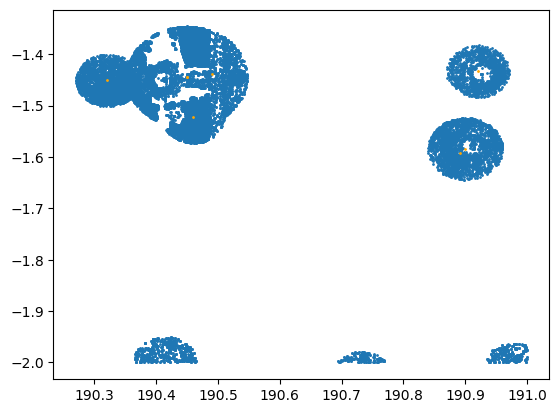

In [22]:
cat_reg1_ghost = cat_reg1[cat_reg1['ghostmask'] == 1]


plt.scatter(cat_reg1_ghost['RAmax'], cat_reg1_ghost ['Decmax'], s=1)
plt.scatter(ghosts_reg1['RA'], ghosts_reg1['Dec'], s=1, color='orange')

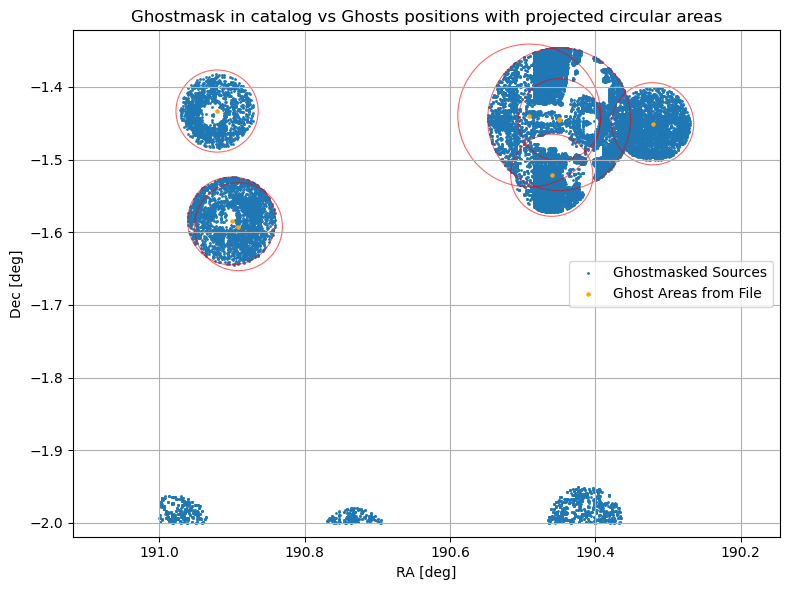

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

plt.figure(figsize=(8, 6))

# Scatter points
plt.scatter(cat_reg1_ghost['RAmax'], cat_reg1_ghost['Decmax'], s=1, label='Ghostmasked Sources')
plt.scatter(ghosts_reg1['RA'], ghosts_reg1['Dec'], s=5, color='orange', label='Ghost Areas from File')

ax = plt.gca()

# Add ellipses to represent projected circular areas
for _, row in ghosts_reg1.iterrows():
    ra = row['RA']
    dec = row['Dec']
    r = row['Radius']  # radius in degrees
    
    # Projected circle: compress RA extent by cos(dec)
    width = 2 * r / np.cos(np.deg2rad(dec))  # in RA direction
    height = 2 * r                           # in Dec direction

    e = Ellipse(
        (ra, dec),
        width=width,
        height=height,
        fill=False,
        edgecolor='red',
        linewidth=0.8,
        alpha=0.6
    )
    ax.add_patch(e)

# Formatting
plt.title("Ghostmask in catalog vs Ghosts positions with projected circular areas")
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.invert_xaxis()  # Sky convention
ax.legend()
ax.grid(True)
ax.set_aspect('equal', adjustable='datalim')  # ensures circular scaling in small areas
plt.tight_layout()
plt.show()
plt.savefig('ghostmask_ghosts_comparison.png', dpi=300)


In [1]:
og_ghopath = '/Users/sp624AA/Code/waves_polygon_mask/23-06-25_masked_objects_list/Masking/GhostLocations_v0.csv'

In [9]:
og_ghosts = pd.read_csv(og_ghopath)

In [11]:
og_ghosts['radius']

0       3.054921
1       3.054921
2       3.054921
3       3.054921
4       3.054921
          ...   
6421    2.400000
6422    2.400000
6423    2.400000
6424    2.400000
6425    2.400000
Name: radius, Length: 6426, dtype: float64

In [15]:
def mask_radius_waves(g):
    """
    Calculate r[deg] based on the given formula.
    Parameters:
        g (float or array-like): Input magnitude.
    Returns:
        numpy.ndarray: Calculated r[deg].
    """
    g = np.asarray(g)  # Ensure g is a NumPy array
    r = np.zeros_like(g, dtype=float)
    mask1 = g > 6
    mask2 = (g > 2.5) & (g <= 6)
    mask3 = (g <= 2.5)
    r[mask1] = 3.39
    r[mask2] = 10**(1.07-0.09*g[mask2])
    r[mask3] = 7
    return r#/60

In [20]:
og_ghosts['re_calculated_radius'] = mask_radius_waves(og_ghosts['mag'])

In [21]:
og_ghosts[['mag', 'radius', 're_calculated_radius']]

,mag,radius,re_calculated_radius
0,9.433572,3.054921,3.39
1,8.740145,3.054921,3.39
2,8.445449,3.054921,3.39
3,9.578464,3.054921,3.39
4,9.104512,3.054921,3.39
...,...,...,...
6421,6.972939,2.400000,3.39
6422,6.972939,2.400000,3.39
6423,6.431121,2.400000,3.39
6424,6.535336,2.400000,3.39


In [19]:
og_ghosts

,tile,ra,dec,star_ra,star_dec,mag,radius,class,tileRA,tileDec,ra_transform,radist,decdist,radius_calc
0,0.0_-27.2,0.360418,-27.571230,0.332255,-27.542222,9.433572,3.054921,2,0.0,-27.2,0.360418,0.405229,0.371230,3.39
1,0.0_-27.2,0.617170,-27.129181,0.567619,-27.134867,8.740145,3.054921,2,0.0,-27.2,0.617170,0.693904,0.070819,3.39
2,0.0_-27.2,0.618115,-27.129453,0.568495,-27.135116,8.445449,3.054921,2,0.0,-27.2,0.618115,0.694967,0.070547,3.39
3,0.0_-27.2,0.115640,-27.021153,0.106028,-27.036020,9.578464,3.054921,2,0.0,-27.2,0.115640,0.130018,0.178847,3.39
4,0.0_-27.2,0.055945,-26.847624,0.051521,-26.875488,9.104512,3.054921,2,0.0,-27.2,0.055945,0.062901,0.352376,3.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6421,8.2_-32.1,8.580472,-32.318920,8.550341,-32.301583,6.972939,2.400000,2,8.2,-32.1,8.580472,0.449135,0.218920,3.39
6422,8.2_-32.1,8.541093,-32.296261,8.513892,-32.280610,6.972939,2.400000,2,8.2,-32.1,8.541093,0.402649,0.196261,3.39
6423,8.5_-35.1,8.419088,-34.985754,8.425940,-34.995430,6.431121,2.400000,2,8.5,-35.1,8.419088,0.098896,0.114246,3.39
6424,9.6_-34.1,10.062209,-33.937450,10.026092,-33.950151,6.535336,2.400000,2,9.6,-34.1,10.062209,0.558183,0.162550,3.39


(array([  3.,   0.,   0.,   0.,   0.,   0.,   3.,   5.,   0.,   3.,  15.,
          8.,  14.,   8.,  10.,  13.,   9.,  23.,  25.,  40.,  28.,  39.,
         42.,  57.,  55.,  82.,  69., 112.,  93., 166., 161., 168., 117.,
         67., 103., 123., 115., 149., 165., 214., 227., 249., 248., 322.,
        391., 426., 463., 531., 589., 676.]),
 array([2.23964882, 2.38685532, 2.53406181, 2.68126831, 2.82847481,
        2.97568131, 3.1228878 , 3.2700943 , 3.4173008 , 3.56450729,
        3.71171379, 3.85892029, 4.00612679, 4.15333328, 4.30053978,
        4.44774628, 4.59495278, 4.74215927, 4.88936577, 5.03657227,
        5.18377876, 5.33098526, 5.47819176, 5.62539826, 5.77260475,
        5.91981125, 6.06701775, 6.21422424, 6.36143074, 6.50863724,
        6.65584374, 6.80305023, 6.95025673, 7.09746323, 7.24466972,
        7.39187622, 7.53908272, 7.68628922, 7.83349571, 7.98070221,
        8.12790871, 8.27511521, 8.4223217 , 8.5695282 , 8.7167347 ,
        8.86394119, 9.01114769, 9.15835419, 9.

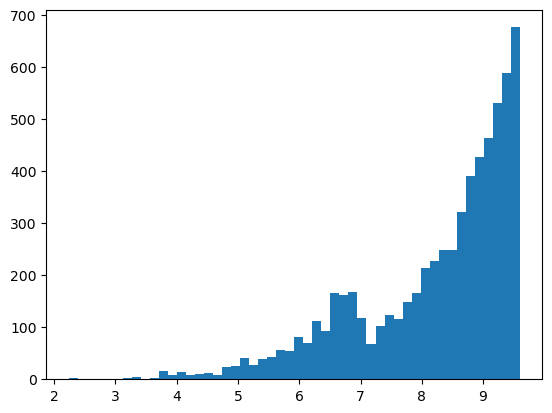

In [23]:
plt.hist(og_ghosts['mag'], bins =50)